# ID5030 Assignment 7
## Recurrent Neural Networks
By: P Akhil Reddy    
Roll No. CH20B076


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import holidays

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("./rnn_dataset.csv")
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


## Part 1: Using previous 100 values as features.

#### Creating a new dataframe where the features are the previous 100 values, and the label is the current value. Using the pandas shift() function.

In [3]:
df_100 = df.copy()

for i in range(1, 101):
    df_100[f"lag{i}"] = df_100["PJMW_MW"].shift(i)

# Removing the first 100 rows of the dataset
df_100 = df_100[100:]

df_100.shape

/tmp/ipykernel_1672668/3846920167.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_100[f"lag{i}"] = df_100["PJMW_MW"].shift(i)


(143106, 102)

In [4]:
df_100.drop(columns=["Datetime"], inplace=True)

### Splitting the data into train, val, and test datasets

In [5]:
train_df = df_100[:100174]
val_df = df_100[100174:121640]
test_df = df_100[121640:]

X_train = train_df.drop(columns=["PJMW_MW"])
y_train = train_df["PJMW_MW"]

X_val = val_df.drop(columns=["PJMW_MW"])
y_val = val_df["PJMW_MW"]

X_test = test_df.drop(columns=["PJMW_MW"])
y_test = test_df["PJMW_MW"]

### Standardising the datasets

In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

### Creating dataloader for the dataset.

In [7]:
batch_size = 64

train_torch = torch.Tensor(X_train_scaled)
val_torch = torch.Tensor(X_val_scaled)
test_torch = torch.Tensor(X_test_scaled)

y_train_torch = torch.Tensor(y_train_scaled)
y_val_torch = torch.Tensor(y_val_scaled)
y_test_torch = torch.Tensor(y_test_scaled)

In [8]:
train_dataset = TensorDataset(train_torch, y_train_torch)
val_dataset = TensorDataset(val_torch, y_val_torch)
test_dataset = TensorDataset(test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Defining the RNN model class.

In [9]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, dropout=dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).requires_grad_()

        output, hidden = self.rnn(x, hidden.detach())  

        output = output[:, -1, :]

        output = self.fc(output)

        return output  

### Creating a function to train the model.

In [10]:
def train(model, loss_func, optimiser, train_loader, val_loader, batch_size, n_epochs, n_features):
    train_losses = []
    val_losses = []
    for epoch in range(1, n_epochs+1):
        batch_losses = []

        # For train dataset
        for x_batch, y_batch in train_loader:
            
            x_batch = x_batch.view([batch_size, -1, n_features])#.to(device)
            
            y_batch = y_batch#.to(device)

            optimiser.zero_grad()

            model.train()

            y_pred = model(x_batch)

            loss = loss_func(y_batch, y_pred)

            loss.backward()

            optimiser.step()

            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        # For validation dataset
        with torch.no_grad():
            batch_losses = []

            for x_val, y_val in val_loader:
                x_val = x_val.view([batch_size, -1, n_features])
                y_val = y_val

                model.eval()

                y_pred = model(x_val)
                val_loss = loss_func(y_val, y_pred)

                batch_losses.append(val_loss.item())
            val_loss = np.mean(batch_losses)
            val_losses.append(val_loss)

        if(epoch%5 == 0):
            print(f"Epoch {epoch}/{n_epochs}: Training loss: {train_loss:.6f}\t Validation loss: {val_loss:.6f}")

    with plt.rc_context({'figure.figsize': (10, 8), 'font.size': 16}):
        plt.plot(train_losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("MSE Loss")
        plt.title("Train and Validation Losses vs Epoch Number")
        plt.show()


### Training the model.

In [11]:
batch_size = 64

input_dim = len(X_train.columns)
hidden_dim = 64
output_dim = 1

layer_dim = 3
dropout = 0.2
n_epochs = 100
lr = 1e-3
weight_decay = 1e-6

model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
loss_fn = nn.MSELoss(reduction="mean")
optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

### Training the model and plotting the learning curve.

/home/akhil/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 5/100: Training loss: 0.044872	 Validation loss: 0.084442
Epoch 10/100: Training loss: 0.035440	 Validation loss: 0.095345
Epoch 15/100: Training loss: 0.031807	 Validation loss: 0.051351
Epoch 20/100: Training loss: 0.026837	 Validation loss: 0.040431
Epoch 25/100: Training loss: 0.025304	 Validation loss: 0.033889
Epoch 30/100: Training loss: 0.024199	 Validation loss: 0.037578
Epoch 35/100: Training loss: 0.022786	 Validation loss: 0.035561
Epoch 40/100: Training loss: 0.022427	 Validation loss: 0.031447
Epoch 45/100: Training loss: 0.021960	 Validation loss: 0.028233
Epoch 50/100: Training loss: 0.021777	 Validation loss: 0.032589
Epoch 55/100: Training loss: 0.021317	 Validation loss: 0.030081
Epoch 60/100: Training loss: 0.021258	 Validation loss: 0.032000
Epoch 65/100: Training loss: 0.020276	 Validation loss: 0.027756
Epoch 70/100: Training loss: 0.019956	 Validation loss: 0.034250
Epoch 75/100: Training loss: 0.019672	 Validation loss: 0.026858
Epoch 80/100: Training los

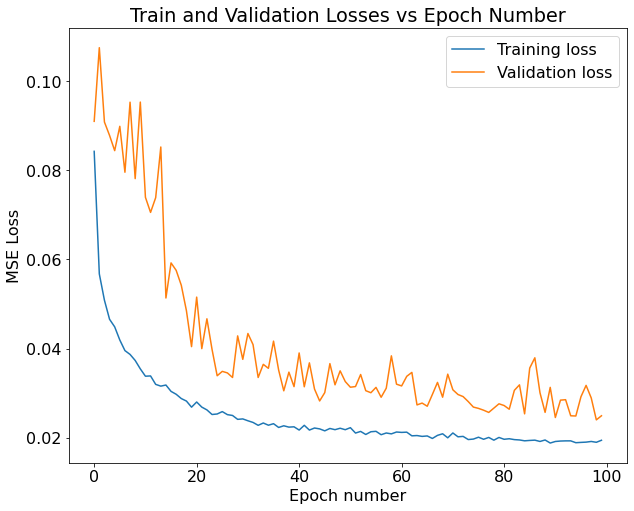

In [12]:
train(model=model, loss_func=loss_fn, optimiser=optimiser, train_loader=train_loader, val_loader=val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

### Evaluating the model on the test dataset

In [13]:
def evaluate(model, test_loader, batch_size, n_features):
    with torch.no_grad():
        r2_scores = []
        rmse_values = []
        mse_values = []

        for x_test, y_test in test_loader:
            x_test = x_test.view([batch_size, -1, n_features])
            
            model.eval()

            y_pred = model(x_test)

            mse = mean_squared_error(y_pred, y_test, squared = True)
            rmse = mean_squared_error(y_pred, y_test, squared = False)
            r2 = r2_score(y_pred, y_test)

            mse_values.append(mse)
            rmse_values.append(rmse)
            r2_scores.append(r2)

    avg_mse = sum(mse_values)/len(mse_values)
    avg_rmse = sum(rmse_values)/len(rmse_values)
    avg_r2 = sum(r2_scores)/len(r2_scores)

    print("EVALUATION RESULTS ON THE TEST DATASET:\n")
    print(f"Mean Squared Error: {avg_mse:.4f}\n")
    print(f"Root Mean Squared Error: {avg_rmse:.4f}\n")
    print(f"R2 score: {avg_r2:.4f}")

In [14]:
evaluate(model=model, test_loader=test_loader, batch_size=batch_size, n_features=input_dim)

EVALUATION RESULTS ON THE TEST DATASET:

Mean Squared Error: 0.0213

Root Mean Squared Error: 0.1346

R2 score: 0.9505


### Part 2: Using date and time as features instead of previous values.

In [53]:
df_time = df.copy()

#### Creating date time features

In [54]:
df_time["Datetime"] = pd.to_datetime(df["Datetime"])

df_time["month"] = df_time["Datetime"].dt.month
df_time["year"] = df_time["Datetime"].dt.year
df_time["day_of_month"] = df_time["Datetime"].dt.day
df_time["day_of_week"] = df_time["Datetime"].dt.day_of_week
df_time["hours"] = df_time["Datetime"].dt.hour
df_time["week_of_year"] = df_time["Datetime"].dt.isocalendar().week

df_time

,Datetime,PJMW_MW,month,year,day_of_month,day_of_week,hours,week_of_year
0,2002-12-31 01:00:00,5077.0,12,2002,31,1,1,1
1,2002-12-31 02:00:00,4939.0,12,2002,31,1,2,1
2,2002-12-31 03:00:00,4885.0,12,2002,31,1,3,1
3,2002-12-31 04:00:00,4857.0,12,2002,31,1,4,1
4,2002-12-31 05:00:00,4930.0,12,2002,31,1,5,1
...,...,...,...,...,...,...,...,...
143201,2018-01-01 20:00:00,8401.0,1,2018,1,0,20,1
143202,2018-01-01 21:00:00,8373.0,1,2018,1,0,21,1
143203,2018-01-01 22:00:00,8238.0,1,2018,1,0,22,1
143204,2018-01-01 23:00:00,7958.0,1,2018,1,0,23,1


### Adding a column to account for holidays.

In [55]:
holidays_ind = []
for year in range(2002, 2019):
    holidays_ind.extend(holidays.India(years=year))

df_time["is_holiday"] = df_time["Datetime"].dt.date.astype("datetime64").isin(holidays_ind).astype(int)

df_time

,Datetime,PJMW_MW,month,year,day_of_month,day_of_week,hours,week_of_year,is_holiday
0,2002-12-31 01:00:00,5077.0,12,2002,31,1,1,1,0
1,2002-12-31 02:00:00,4939.0,12,2002,31,1,2,1,0
2,2002-12-31 03:00:00,4885.0,12,2002,31,1,3,1,0
3,2002-12-31 04:00:00,4857.0,12,2002,31,1,4,1,0
4,2002-12-31 05:00:00,4930.0,12,2002,31,1,5,1,0
...,...,...,...,...,...,...,...,...,...
143201,2018-01-01 20:00:00,8401.0,1,2018,1,0,20,1,0
143202,2018-01-01 21:00:00,8373.0,1,2018,1,0,21,1,0
143203,2018-01-01 22:00:00,8238.0,1,2018,1,0,22,1,0
143204,2018-01-01 23:00:00,7958.0,1,2018,1,0,23,1,0


### For features which have periodic features, it is better to have the sine of those features instead of the actual values.

In [56]:
df_time["month_sin"] = np.sin((2*np.pi*df_time["month"])/12)
df_time["day_of_week_sin"] = np.sin((2*np.pi*df_time["day_of_week"])/7)
df_time["day_of_month_sin"] = np.sin((2*np.pi*df_time["day_of_month"])/31)
df_time["hours_sin"] = np.sin((2*np.pi*df_time["hours"])/24)
df_time["week_of_year_sin"] = np.sin((2*np.pi*df_time["week_of_year"])/53)

df_time.drop(columns=["day_of_month", "day_of_week", "hours", "week_of_year", "month", "Datetime"], inplace=True)

In [57]:
# Standardising the year column
avg = df_time["year"].mean()
std = df_time["year"].std()

df_time["year"] = (df_time["year"] - avg)/std

df_time

,PJMW_MW,year,is_holiday,month_sin,day_of_week_sin,day_of_month_sin,hours_sin,week_of_year_sin
0,5077.0,-1.674020,0,-2.449294e-16,0.781831,-2.449294e-16,0.258819,0.118273
1,4939.0,-1.674020,0,-2.449294e-16,0.781831,-2.449294e-16,0.500000,0.118273
2,4885.0,-1.674020,0,-2.449294e-16,0.781831,-2.449294e-16,0.707107,0.118273
3,4857.0,-1.674020,0,-2.449294e-16,0.781831,-2.449294e-16,0.866025,0.118273
4,4930.0,-1.674020,0,-2.449294e-16,0.781831,-2.449294e-16,0.965926,0.118273
...,...,...,...,...,...,...,...,...
143201,8401.0,1.708398,0,5.000000e-01,0.000000,2.012985e-01,-0.866025,0.118273
143202,8373.0,1.708398,0,5.000000e-01,0.000000,2.012985e-01,-0.707107,0.118273
143203,8238.0,1.708398,0,5.000000e-01,0.000000,2.012985e-01,-0.500000,0.118273
143204,7958.0,1.708398,0,5.000000e-01,0.000000,2.012985e-01,-0.258819,0.118273


#### Splitting the data into train, val and test datasets.

In [58]:
train_df = df_time[:100244]
val_df = df_time[100244:121725]
test_df = df_time[121725:]

X_train = train_df.drop(columns=["PJMW_MW"])
y_train = train_df["PJMW_MW"]

X_val = val_df.drop(columns=["PJMW_MW"])
y_val = val_df["PJMW_MW"]

X_test = test_df.drop(columns=["PJMW_MW"])
y_test = test_df["PJMW_MW"]

### Creating tensor datasets and loading them into dataloaders.

In [59]:
batch_size = 64

input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1

layer_dim = 3
dropout = 0.2
n_epochs = 50
lr = 1e-1
weight_decay = 1e-6

model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
loss_fn = nn.MSELoss(reduction="mean")
optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [60]:
train_torch = torch.Tensor(X_train.values.astype("float64"))
val_torch = torch.Tensor(X_val.values.astype("float64"))
test_torch = torch.Tensor(X_test.values.astype("float64"))

y_train_torch = torch.Tensor(y_train.values.astype("float64"))
y_val_torch = torch.Tensor(y_val.values.astype("float64"))
y_test_torch = torch.Tensor(y_test.values.astype("float64"))

In [61]:
train_dataset = TensorDataset(train_torch, y_train_torch)
val_dataset = TensorDataset(val_torch, y_val_torch)
test_dataset = TensorDataset(test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Training the model.

/home/akhil/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/50: Training loss: 925907.404798	 Validation loss: 1131665.044263
Epoch 10/50: Training loss: 926033.822528	 Validation loss: 1131767.851446
Epoch 15/50: Training loss: 926083.747555	 Validation loss: 1131772.110728
Epoch 20/50: Training loss: 925544.522739	 Validation loss: 1131261.344170
Epoch 25/50: Training loss: 927028.030686	 Validation loss: 1132095.000886
Epoch 30/50: Training loss: 925825.401710	 Validation loss: 1145897.869496
Epoch 35/50: Training loss: 930206.245141	 Validation loss: 1129762.964132
Epoch 40/50: Training loss: 945699.619298	 Validation loss: 1185186.322854
Epoch 45/50: Training loss: 941582.028017	 Validation loss: 1151701.089785
Epoch 50/50: Training loss: 926108.824363	 Validation loss: 1132072.768004


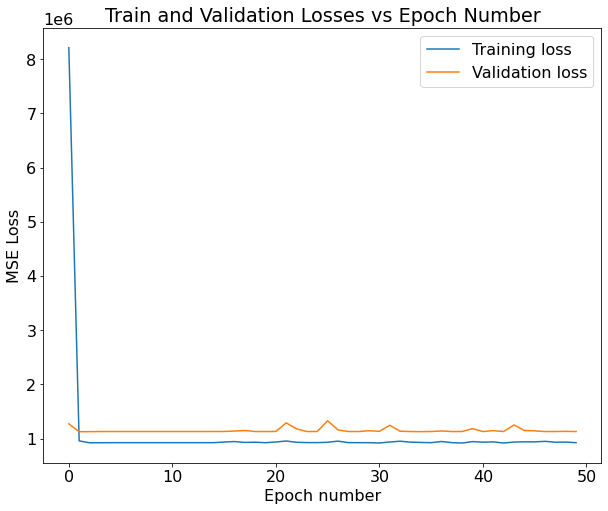

In [62]:
train(model=model, loss_func=loss_fn, optimiser=optimiser, train_loader=train_loader, val_loader=val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

### Evaluating the model on the test dataset.

In [63]:
evaluate(model=model, test_loader=test_loader, batch_size=batch_size, n_features=input_dim)

EVALUATION RESULTS ON THE TEST DATASET:

Mean Squared Error: 1036610.9458

Root Mean Squared Error: 942.7967

R2 score: 0.0000


### Comparision of test results of the RNN model on both datasets.

#### It is observed that for the training of RNN on the dataset which had previous 100 values as features, the following were the results on the test dataset:

Mean Squared Error: 0.0213

Root Mean Squared Error: 0.1346

R2 score: 0.9505

#### For the dataset which had only year, day of week, day of month, week of year, and hours as features, the following were the results on the test dataset:

Mean Squared Error: 1036610.9458

Root Mean Squared Error: 942.7967

R2 score: 0.0000

#### Clearly the first feature engineering method yielded better results than the second feature engineering method. Also it should be observed that for second method, an abnormally low accuracy was reported from which we can hypothesise that something is wrong with the method and further feature engineering is needed for it to reach any further conclusions.